<a href="https://colab.research.google.com/github/mloachamin/MyWeb/blob/main/Optimiza_Enjambre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Algoritmo de Optimización con enjambre de partículas

In [ ]:
################################################################################
# LIBRERÍAS NECESARIAS
################################################################################
import numpy as np
import random
import warnings
import random
import copy
import pandas as pd
import time
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# Configuración warnings
################################################################################
import warnings
warnings.filterwarnings('ignore')

Clase Partícula

In [ ]:
################################################################################
#                              CLASE PARTÍCULA                                 #
################################################################################

class Particula:
    """Esta clase representa nueva partícula con una posición inicial definida por
    una combinación de valores numéricos aleatorios y velocidad de 0. El rango
    de posibles valores para cada variable (posición) puede estar acotado. Al
    crear una nueva partícula, solo se dispone de información sobre su posición
    inicial y velocidad, el resto de atributos están vacíos.

    Parameters
    ----------
    n_variables : `int`
        número de variables que definen la posición de la partícula.

    limites_inf : `list` or `numpy.ndarray`, optional
        límite inferior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados
        por el valor (-10**3). (default is ``None``)

    limites_sup : `list` or `numpy.ndarray`, optional
        límite superior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados
        por el valor (+10**3). (default is ``None``)

    verbose : `bool`, optional
        mostrar información de la partícula creada. (default is ``False``)

    Attributes
    ----------
    n_variables : `int`
        número de variables que definen la posición de la partícula.

    limites_inf : `list` or `numpy.ndarray`
        límite inferior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados por
        el valor (-10**3).

    limites_sup : `list` or `numpy.ndarray`
        límite superior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los``None`` serán remplazados por
        el valor (+10**3).

    mejor_valor : `numpy.ndarray`
        mejor valor que ha tenido la partícula hasta el momento.

    mejor_posicion : `numpy.ndarray`
        posición en la que la partícula ha tenido el mejor valor hasta el momento.

    valor : `float`
        valor actual de la partícula. Resultado de evaluar la función objetivo
        con la posición actual.

    velocidad : `numpy.ndarray`
        array con la velocidad actual de la partícula.

    Raises
    ------
    raise Exception
        si `limites_inf` es distinto de None y su longitud no coincide con
        `n_variables`.

    raise Exception
        si `limites_sup` es distinto de None y su longitud no coincide con
        `n_variables`.

    Examples
    --------
    Ejemplo creación partícula.

    >>> part = Particula(
                    n_variables = 3,
                    limites_inf = [4,10,20],
                    limites_sup = [-1,2,0],
                    verbose     = True
                    )

    """

    def __init__(self, n_variables, limites_inf=None, limites_sup=None,
                 verbose=False):

        # Número de variables de la partícula
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Posición de la partícula
        self.posicion = np.repeat(None, n_variables)
        # Velocidad de la parícula
        self.velocidad = np.repeat(None, n_variables)
        # Valor de la partícula
        self.valor = np.repeat(None, 1)
        # Mejor valor que ha tenido la partícula hasta el momento
        self.mejor_valor = None
        # Mejor posición en la que ha estado la partícula hasta el momento
        self.mejor_posicion = None

        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if self.limites_inf is not None \
        and len(self.limites_inf) != self.n_variables:
            raise Exception(
                "limites_inf debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_inf = [10, None, 5]"
                )
        elif self.limites_sup is not None \
        and len(self.limites_sup) != self.n_variables:
            raise Exception(
                "limites_sup debe tener un valor por cada variable. " +
                "Si para alguna variable no se quiere límite, emplear None. " +
                "Ejemplo: limites_sup = [10, None, 5]"
                )
        elif (self.limites_inf is None) or (self.limites_sup is None):
            warnings.warn(
                "Es altamente recomendable indicar los límites dentro de los " +
                "cuales debe buscarse la solución de cada variable. " +
                "Por defecto se emplea [-10^3, 10^3]."
                )
        elif any(np.concatenate((self.limites_inf, self.limites_sup)) == None):
            warnings.warn(
                "Los límites empleados por defecto cuando no se han definido " +
                "son: [-10^3, 10^3]."
            )

        # COMPROBACIONES INICIALES: ACCIONES
        # ----------------------------------------------------------------------

        # Si no se especifica limites_inf, el valor mínimo que pueden tomar las
        # variables es -10^3.
        if self.limites_inf is None:
            self.limites_inf = np.repeat(-10**3, self.n_variables)

        # Si no se especifica limites_sup, el valor máximo que pueden tomar las
        # variables es 10^3.
        if self.limites_sup is None:
             self.limites_sup = np.repeat(+10**3, self.n_variables)

        # Si los límites no son nulos, se reemplazan aquellas posiciones None por
        # el valor por defecto -10^3 y 10^3.
        if self.limites_inf is not None:
            self.limites_inf[self.limites_inf == None] = -10**3

        if self.limites_sup is not None:
            self.limites_sup[self.limites_sup == None] = +10**3

        # BUCLE PARA ASIGNAR UN VALOR A CADA UNA DE LAS VARIABLES QUE DEFINEN LA
        # POSICIÓN
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_variables):
        # Para cada posición, se genera un valor aleatorio dentro del rango
        # permitido para esa variable.
            self.posicion[i] = random.uniform(
                                    self.limites_inf[i],
                                    self.limites_sup[i]
                                )

        # LA VELOCIDAD INICIAL DE LA PARTÍCULA ES 0
        # ----------------------------------------------------------------------
        self.velocidad = np.repeat(0, self.n_variables)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("Nueva partícula creada")
            print("----------------------")
            print("Posición: " + str(self.posicion))
            print("Límites inferiores de cada variable: " \
                  + str(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + str(self.limites_sup))
            print("Velocidad: " + str(self.velocidad))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto partícula.

        """

        texto = "Partícula" \
                + "\n" \
                + "---------" \
                + "\n" \
                + "Posición: " + str(self.posicion) \
                + "\n" \
                + "Velocidad: " + str(self.velocidad) \
                + "\n" \
                + "Mejor posicion: " + str(self.mejor_posicion) \
                + "\n" \
                + "Mejor valor: " + str(self.mejor_valor) \
                + "\n" \
                + "Límites inferiores de cada variable: " \
                + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " \
                + str(self.limites_sup) \
                + "\n"

        return(texto)

    def evaluar_particula(self, funcion_objetivo, optimizacion, verbose = False):
        """Este método evalúa una partícula calculando el valor que toma la
        función objetivo en la posición en la que se encuentra. Además, compara
        si la nueva posición es mejor que las anteriores. Modifica los atributos
        valor, mejor_valor y mejor_posicion de la partícula.

        Parameters
        ----------
        funcion_objetivo : `function`
            función que se quiere optimizar.

        optimizacion : {'maximizar', 'minimizar'}
            dependiendo de esto, el mejor valor histórico de la partícula será
            el mayor o el menor valor que ha tenido hasta el momento.

        verbose : `bool`, optional
            mostrar información del proceso por pantalla. (default is ``False``)

        Raises
        ------
        raise Exception
            si el argumento `optimizacion` es distinto de 'maximizar' o 'minimizar'

        Examples
        --------
        Ejemplo evaluar partícula con una función objetivo.

        >>> part = Particula(
                n_variables = 3,
                limites_inf = [4,10,20],
                limites_sup = [-1,2,None],
                verbose     = True
                )

        >>> def funcion_objetivo(x_0, x_1, x_2):
                f= x_0**2 + x_1**2 + x_2**2
                return(f)

        >>> part.evaluar_particula(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "maximizar",
                verbose          = True
                )

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        if not optimizacion in ["maximizar", "minimizar"]:
            raise Exception(
                "El argumento optimizacion debe ser: maximizar o minimizar"
                )

        # EVALUACIÓN DE LA FUNCIÓN OBJETIVO EN LA POSICIÓN ACTUAL
        # ----------------------------------------------------------------------
        self.valor = funcion_objetivo(*self.posicion)

        # MEJOR VALOR Y POSICIÓN
        # ----------------------------------------------------------------------
        # Se compara el valor actual con el mejor valor histórico. La comparación
        # es distinta dependiendo de si se desea maximizar o minimizar.
        # Si no existe ningún valor histórico, se almacena el actual. Si ya existe
        # algún valor histórico se compara con el actual y, de ser mejor este
        # último, se sobrescribe.

        if self.mejor_valor is None:
            self.mejor_valor    = np.copy(self.valor)
            self.mejor_posicion = np.copy(self.posicion)
        else:
            if optimizacion == "minimizar":
                if self.valor < self.mejor_valor:
                    self.mejor_valor    = np.copy(self.valor)
                    self.mejor_posicion = np.copy(self.posicion)
            else:
                if self.valor > self.mejor_valor:
                    self.mejor_valor    = np.copy(self.valor)
                    self.mejor_posicion = np.copy(self.posicion)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("La partícula ha sido evaluada")
            print("-----------------------------")
            print("Valor actual: " + str(self.valor))
            print("")

    def mover_particula(self, mejor_p_enjambre, inercia=0.8, peso_cognitivo=2,
                        peso_social=2, verbose=False):
        """
        Este método ejecuta el movimiento de una partícula, lo que implica
        actualizar su velocidad y posición. No se permite que la partícula
        salga de la zona de búsqueda acotada por los límites.

        Parameters
        ----------
        mejor_p_enjambre : `np.narray`
            mejor posición de todo el enjambre.

        inercia : `float`, optional
            coeficiente de inercia. (default is 0.8)

        peso_cognitivo : `float`, optional
            coeficiente cognitivo. (default is 2)

        peso_social : `float`, optional
            coeficiente social. (default is 2)

        verbose : `bool`, optional
            mostrar información de la partícula creada. (default is ``False``)

        Examples
        --------
        Ejemplo mover partícula.

        >>> part = Particula(
                n_variables = 3,
                limites_inf = [4,10,20],
                limites_sup = [-1,2,None],
                verbose     = True
                )

        >>> def funcion_objetivo(x_0, x_1, x_2):
                f= x_0**2 + x_1**2 + x_2**2
                return(f)

        >>> part.evaluar_particula(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "maximizar",
                verbose          = True
                )

        >>> part.mover_particula(
                mejor_p_enjambre = np.array([-1000,-1000,+1000]),
                inercia          = 0.8,
                peso_cognitivo   = 2,
                peso_social      = 2,
                verbose          = True
                )

        """

        # ACTUALIZACIÓN DE LA VELOCIDAD
        # ----------------------------------------------------------------------
        componente_velocidad = inercia * self.velocidad
        r1 = np.random.uniform(low=0.0, high=1.0, size = len(self.velocidad))
        r2 = np.random.uniform(low=0.0, high=1.0, size = len(self.velocidad))
        componente_cognitivo = peso_cognitivo * r1 * (self.mejor_posicion \
                                                      - self.posicion)
        componente_social = peso_social * r2 * (mejor_p_enjambre \
                                                - self.posicion)
        nueva_velocidad = componente_velocidad + componente_cognitivo \
                          + componente_social
        self.velocidad = np.copy(nueva_velocidad)

        # ACTUALIZACIÓN DE LA POSICIÓN
        # ----------------------------------------------------------------------
        self.posicion = self.posicion + self.velocidad

        # COMPROBAR LÍMITES
        # ----------------------------------------------------------------------
        # Se comprueba si algún valor de la nueva posición supera los límites
        # impuestos. En tal caso, se sobrescribe con el valor del límite
        # correspondiente y se reinicia a 0 la velocidad de la partícula en esa
        # componente.
        for i in np.arange(len(self.posicion)):
            if self.posicion[i] < self.limites_inf[i]:
                self.posicion[i] = self.limites_inf[i]
                self.velocidad[i] = 0

            if self.posicion[i] > self.limites_sup[i]:
                self.posicion[i] = self.limites_sup[i]
                self.velocidad[i] = 0

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("La partícula se ha desplazado")
            print("-----------------------------")
            print("Nueva posición: " + str(self.posicion))
            print("")

Clase Enjambre

In [ ]:
################################################################################
#                              CLASE ENJAMBRE (SWARM)                          #
################################################################################

class Enjambre:
    """
    Esta clase crea un enjambre de n partículas. El rango de posibles valores
    para cada variable (posición) puede estar acotado.

    Parameters
    ----------
    n_particulas :`int`
        número de partículas del enjambre.

    n_variables : `int`
        número de variables que definen la posición de las partícula.

    limites_inf : `list` or `numpy.ndarray`
        límite inferior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los ``None`` serán remplazados por
        el valor (-10**3).

    limites_sup : `list` or `numpy.ndarray`
        límite superior de cada variable. Si solo se quiere predefinir límites
        de alguna variable, emplear ``None``. Los``None`` serán remplazados por
        el valor (+10**3).

    verbose : `bool`, optional
        mostrar información de la partícula creada. (default is ``False``)

    Attributes
    ----------
    partículas : `list`
        lista con todas las partículas del enjambre.

    n_particulas :`int`
        número de partículas del enjambre.

    n_variables : `int`
        número de variables que definen la posición de las partícula.

    limites_inf : `list` or `numpy.ndarray`
        límite inferior de cada variable.

    limites_sup : `list` or `numpy.ndarray`
        límite superior de cada variable.

    mejor_particula : `object particula`
        la mejor partícula del enjambre en estado actual.

    mejor_valor : `floar`
        el mejor valor del enjambre en su estado actual.

    historico_particulas : `list`
        lista con el estado de las partículas en cada una de las iteraciones que
        ha tenido el enjambre.

    historico_mejor_posicion : `list`
        lista con la mejor posición en cada una de las iteraciones que ha tenido
        el enjambre.

    historico_mejor_valor : `list`
        lista con el mejor valor en cada una de las iteraciones que ha tenido el
        enjambre.

    diferencia_abs : `list`
        diferencia absoluta entre el mejor valor de iteraciones consecutivas.

    resultados_df : `pandas.core.frame.DataFrame`
        dataframe con la información del mejor valor y posición encontrado en
        cada iteración, así como la mejora respecto a la iteración anterior.

    valor_optimo : `float`
        mejor valor encontrado en todas las iteraciones.

    posicion_optima : `numpy.narray`
        posición donde se ha encontrado el valor_optimo.

    optimizado : `bool`
        si el enjambre ha sido optimizado.

    iter_optimizacion : `int`
        número de iteraciones de optimizacion.

    verbose : `bool`, optional
        mostrar información de la partícula creada. (default is ``False``)

    Examples
    --------
    Ejemplo crear enjambre

    >>> enjambre = Enjambre(
               n_particulas = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

    """

    def __init__(self, n_particulas, n_variables, limites_inf = None,
                 limites_sup = None, verbose = False):

        # Número de partículas del enjambre
        self.n_particulas = n_particulas
        # Número de variables de cada partícula
        self.n_variables = n_variables
        # Límite inferior de cada variable
        self.limites_inf = limites_inf
        # Límite superior de cada variable
        self.limites_sup = limites_sup
        # Verbose
        self.verbose = verbose
        # Lista de las partículas del enjambre
        self.particulas = []
        # Etiqueta para saber si el enjambre ha sido optimizado
        self.optimizado = False
        # Número de iteraciones de optimización llevadas a cabo
        self.iter_optimizacion = None
        # Mejor partícula del enjambre
        self.mejor_particula = None
        # Mejor valor del enjambre
        self.mejor_valor = None
        # Posición del mejor valor del enjambre.
        self.mejor_posicion = None
        # Estado de todas las partículas del enjambre en cada iteración.
        self.historico_particulas = []
        # Mejor posición en cada iteración.
        self.historico_mejor_posicion = []
        # Mejor valor en cada iteración.
        self.historico_mejor_valor = []
        # Diferencia absoluta entre el mejor valor de iteraciones consecutivas.
        self.diferencia_abs = []
        # data.frame con la información del mejor valor y posición encontrado en
        # cada iteración, así como la mejora respecto a la iteración anterior.
        self.resultados_df = None
        # Mejor valor de todas las iteraciones
        self.valor_optimo = None
        # Mejor posición de todas las iteraciones
        self.posicion_optima = None

        # CONVERSIONES DE TIPO INICIALES
        # ----------------------------------------------------------------------
        # Si limites_inf o limites_sup no son un array numpy, se convierten en
        # ello.
        if self.limites_inf is not None \
        and not isinstance(self.limites_inf,np.ndarray):
            self.limites_inf = np.array(self.limites_inf)

        if self.limites_sup is not None \
        and not isinstance(self.limites_sup,np.ndarray):
            self.limites_sup = np.array(self.limites_sup)

        # SE CREAN LAS PARTÍCULAS DEL ENJAMBRE Y SE ALMACENAN
        # ----------------------------------------------------------------------
        for i in np.arange(n_particulas):
            particula_i = Particula(
                            n_variables = self.n_variables,
                            limites_inf = self.limites_inf,
                            limites_sup = self.limites_sup,
                            verbose     = self.verbose
                          )
            self.particulas.append(particula_i)

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("---------------")
            print("Enjambre creado")
            print("---------------")
            print("Número de partículas: " + str(self.n_particulas))
            print("Límites inferiores de cada variable: " \
                  + np.array2string(self.limites_inf))
            print("Límites superiores de cada variable: " \
                  + np.array2string(self.limites_sup))
            print("")

    def __repr__(self):
        """
        Información que se muestra cuando se imprime un objeto enjambre.

        """

        texto = "============================" \
                + "\n" \
                + "         Enjambre" \
                + "\n" \
                + "============================" \
                + "\n" \
                + "Número de partículas: " + str(self.n_particulas) \
                + "\n" \
                + "Límites inferiores de cada variable: " + str(self.limites_inf) \
                + "\n" \
                + "Límites superiores de cada variable: " + str(self.limites_sup) \
                + "\n" \
                + "Optimizado: " + str(self.optimizado) \
                + "\n" \
                + "Iteraciones optimización: " + str(self.iter_optimizacion) \
                + "\n" \
                + "\n" \
                + "Información mejor partícula:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Mejor posición actual: " + str(self.mejor_posicion) \
                + "\n" \
                + "Mejor valor actual: " + str(self.mejor_valor) \
                + "\n" \
                + "\n" \
                + "Resultados tras optimizar:" \
                + "\n" \
                + "----------------------------" \
                + "\n" \
                + "Posición óptima: " + str(self.posicion_optima) \
                + "\n" \
                + "Valor óptimo: " + str(self.valor_optimo)

        return(texto)

    def mostrar_particulas(self, n=None):
        """
        Este método muestra la información de cada una de las n primeras
        partículas del enjambre.

        Parameters
        ----------

        n : `int`
            número de particulas que se muestran. Si no se indica el valor
            (por defecto ``None``), se muestran todas. Si el valor es mayor
            que `self.n_particulas` se muestran todas.

        Examples
        --------
        >>> enjambre = Enjambre(
               n_particulas = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

        >>> enjambre.mostrar_particulas(n = 1)

        """

        if n is None:
            n = self.n_particulas
        elif n > self.n_particulas:
            n = self.n_particulas

        for i in np.arange(n):
            print(self.particulas[i])
        return(None)

    def evaluar_enjambre(self, funcion_objetivo, optimizacion, verbose = False):
        """
        Este método evalúa todas las partículas del enjambre, actualiza sus
        valores e identifica la mejor partícula.

        Parameters
        ----------
        funcion_objetivo : `function`
            función que se quiere optimizar.

        optimizacion : {maximizar o minimizar}
            Dependiendo de esto, el mejor valor histórico de la partícula será
            el mayor o el menor valorque ha tenido hasta el momento.

        verbose : `bool`, optional
            mostrar información de la partícula creada. (default is ``False``)

        Examples
        --------
        Ejemplo evaluar enjambre

        >>> enjambre = Enjambre(
               n_particulas = 5,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

        >>> def funcion_objetivo(x_0, x_1, x_2):
                f= x_0**2 + x_1**2 + x_2**2
                return(f)

        >>> enjambre.evaluar_enjambre(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                verbose          = True
                )

        """

        # SE EVALÚA CADA PARTÍCULA DEL ENJAMBRE
        # ----------------------------------------------------------------------
        for i in np.arange(self.n_particulas):
            self.particulas[i].evaluar_particula(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = optimizacion,
                verbose          = verbose
                )

        # MEJOR PARTÍCULA DEL ENJAMBRE
        # ----------------------------------------------------------------------
        # Se identifica la mejor partícula de todo el enjambre. Si se está
        # maximizando, la mejor partícula es aquella con mayor valor.
        # Lo contrario si se está minimizando.

        # Se selecciona inicialmente como mejor partícula la primera.
        self.mejor_particula =  copy.deepcopy(self.particulas[0])
        # Se comparan todas las partículas del enjambre.
        for i in np.arange(self.n_particulas):
            if optimizacion == "minimizar":
                if self.particulas[i].valor < self.mejor_particula.valor:
                    self.mejor_particula = copy.deepcopy(self.particulas[i])
            else:
                if self.particulas[i].valor > self.mejor_particula.valor:
                    self.mejor_particula = copy.deepcopy(self.particulas[i])

        # Se extrae la posición y valor de la mejor partícula y se almacenan
        # como mejor valor y posición del enjambre.
        self.mejor_valor    = self.mejor_particula.valor
        self.mejor_posicion = self.mejor_particula.posicion

        # INFORMACIÓN DEL PROCESO (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("-----------------")
            print("Enjambre evaluado")
            print("-----------------")
            print("Mejor posición encontrada : "
                  + np.array2string(self.mejor_posicion))
            print("Mejor valor encontrado : " + str(self.mejor_valor))
            print("")

    def mover_enjambre(self, inercia, peso_cognitivo, peso_social,
                       verbose = False):
        """
        Este método mueve todas las partículas del enjambre.

        Parameters
        ----------
        optimizacion : {maximizar o minimizar}
            si se desea maximizar o minimizar la función.

        inercia : `float` or `int`
            coeficiente de inercia.

        peso_cognitivo : `float` or `int`
            coeficiente cognitivo.

        peso_social : `float` or `int`
            coeficiente social.

        verbose : `bool`, optional
            mostrar información de la partícula creada. (default is ``False``)

        """

        # Se actualiza la posición de cada una de las partículas que forman el
        # enjambre.
        for i in np.arange(self.n_particulas):
            self.particulas[i].mover_particula(
                mejor_p_enjambre = self.mejor_posicion,
                inercia          = inercia,
                peso_cognitivo   = peso_cognitivo,
                peso_social      = peso_social,
                verbose          = verbose
            )

        # Información del proceso (VERBOSE)
        # ----------------------------------------------------------------------
        if verbose:
            print("---------------------------------------------------------" \
                  "------------")
            print("La posición de todas las partículas del enjambre ha sido " \
                  "actualizada.")
            print("---------------------------------------------------------" \
            "------------")
            print("")


    def optimizar(self, funcion_objetivo, optimizacion, n_iteraciones = 50,
                  inercia = 0.8, reduc_inercia = True, inercia_max = 0.9,
                  inercia_min = 0.4, peso_cognitivo = 2, peso_social = 2,
                  parada_temprana = False, rondas_parada = None,
                  tolerancia_parada  = None, verbose = False):
        """
        Este método realiza el proceso de optimización de un enjambre.

        Parameters
        ----------
        funcion_objetivo : `function`
            función que se quiere optimizar.

        optimizacion : {maximizar o minimizar}
            si se desea maximizar o minimizar la función.

        m_iteraciones : `int` , optional
            numero de iteraciones de optimización. (default is ``50``)

        inercia : `float` or `int`, optional
            coeficiente de inercia. (default is ``0.8``)

        peso_cognitivo : `float` or `int`, optional
            coeficiente cognitivo. (default is ``2``)

        peso_social : `float` or `int`, optional
            coeficiente social. (default is ``2``)

        reduc_inercia: `bool`, optional
           activar la reducción del coeficiente de inercia. En tal caso, el
           argumento `inercia` es ignorado. (default is ``True``)

        inercia_max : `float` or `int`, optional
            valor inicial del coeficiente de inercia si se activa `reduc_inercia`.
            (default is ``0.9``)

        inercia_min : `float` or `int`, optional
            valor minimo del coeficiente de inercia si se activa `reduc_min`.
            (default is ``0.4``)

        parada_temprana : `bool`, optional
            si durante las últimas `rondas_parada` generaciones la diferencia
            absoluta entre mejores individuos no es superior al valor de
            `tolerancia_parada`, se detiene el algoritmo y no se crean nuevas
            generaciones. (default is ``False``)

        rondas_parada : `int`, optional
            número de generaciones consecutivas sin mejora mínima para que se
            active la parada temprana. (default is ``None``)

        tolerancia_parada : `float` or `int`, optional
            valor mínimo que debe tener la diferencia de generaciones consecutivas
            para considerar que hay cambio. (default is ``None``)

         verbose : `bool`, optional
            mostrar información de la partícula creada. (default is ``False``)

        Raises
        ------
        raise Exception
            si se indica `parada_temprana = True` y los argumentos `rondas_parada`
            o `tolerancia_parada` son ``None``.

        raise Exception
            si se indica `reduc_inercia = True` y los argumentos `inercia_max`
            o `inercia_min` son ``None``.

        Examples
        --------
        Ejemplo optimización

        >>> def funcion_objetivo(x_0, x_1):
                # Para la región acotada entre −10<=x_0<=0 y −6.5<=x_1<=0 la
                # función tiene múltiples mínimos locales y un único minimo
                # global en f(−3.1302468,−1.5821422)= −106.7645367.
                f = np.sin(x_1)*np.exp(1-np.cos(x_0))**2 \
                    + np.cos(x_0)*np.exp(1-np.sin(x_1))**2 \
                    + (x_0-x_1)**2
                return(f)

        >>> enjambre = Enjambre(
                        n_particulas = 50,
                        n_variables  = 2,
                        limites_inf  = [-10, -6.5],
                        limites_sup  = [0, 0],
                        verbose      = False
                        )

        >>> enjambre.optimizar(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                n_iteraciones    = 250,
                inercia          = 0.8,
                reduc_inercia    = True,
                inercia_max      = 0.9,
                inercia_min      = 0.4,
                peso_cognitivo   = 1,
                peso_social      = 2,
                parada_temprana  = True,
                rondas_parada    = 5,
                tolerancia_parada = 10**-3,
                verbose          = False
            )

        """

        # COMPROBACIONES INICIALES: EXCEPTIONS Y WARNINGS
        # ----------------------------------------------------------------------
        # Si se activa la parada temprana, hay que especificar los argumentos
        # rondas_parada y tolerancia_parada.
        if parada_temprana \
        and (rondas_parada is None or tolerancia_parada is None):
            raise Exception(
                "Para activar la parada temprana es necesario indicar un " \
                + " valor de rondas_parada y de tolerancia_parada."
                )

        # Si se activa la reducción de inercia, hay que especificar los argumentos
        # inercia_max y inercia_min.
        if reduc_inercia \
        and (inercia_max is None or inercia_min is None):
            raise Exception(
            "Para activar la reducción de inercia es necesario indicar un " \
            + "valor de inercia_max y de inercia_min."
            )

        # ITERACIONES
        # ----------------------------------------------------------------------
        start = time.time()

        for i in np.arange(n_iteraciones):
            if verbose:
                print("-------------")
                print("Iteracion: " + str(i))
                print("-------------")

            # EVALUAR PARTÍCULAS DEL ENJAMBRE
            # ------------------------------------------------------------------
            enjambre.evaluar_enjambre(
                funcion_objetivo = funcion_objetivo,
                optimizacion     = "minimizar",
                verbose          = verbose
                )

            # SE ALMACENA LA INFORMACIÓN DE LA ITERACIÓN EN LOS HISTÓRICOS
            # ------------------------------------------------------------------
            self.historico_particulas.append(copy.deepcopy(self.particulas))
            self.historico_mejor_posicion.append(copy.deepcopy(self.mejor_posicion))
            self.historico_mejor_valor.append(copy.deepcopy(self.mejor_valor))

            # SE CALCULA LA DIFERENCIA ABSOLUTA RESPECTO A LA ITERACION ANTERIOR
            # ------------------------------------------------------------------
            # La diferencia solo puede calcularse a partir de la segunda
            # iteración.
            if i == 0:
                self.diferencia_abs.append(None)
            else:
                diferencia = abs(self.historico_mejor_valor[i] \
                                 - self.historico_mejor_valor[i-1])
                self.diferencia_abs.append(diferencia)

            # CRITERIO DE PARADA
            # ------------------------------------------------------------------
            # Si durante las últimas n generaciones, la diferencia absoluta entre
            # mejores partículas no es superior al valor de tolerancia_parada,
            # se detiene el algoritmo y no se crean nuevas generaciones.
            if parada_temprana and i > rondas_parada:
                ultimos_n = np.array(self.diferencia_abs[-(rondas_parada): ])
                if all(ultimos_n < tolerancia_parada):
                    print("Algoritmo detenido en la iteracion "
                          + str(i) \
                          + " por falta cambio absoluto mínimo de " \
                          + str(tolerancia_parada) \
                          + " durante " \
                          + str(rondas_parada) \
                          + " iteraciones consecutivas.")
                    break

            # MOVER PARTÍCULAS DEL ENJAMBRE
            # ------------------------------------------------------------------
            # Si se ha activado la reducción de inercia, se recalcula su valor
            # para la iteración actual.
            if reduc_inercia:
                inercia = ((inercia_max - inercia_min) \
                          * (n_iteraciones-i)/n_iteraciones) \
                          + inercia_min

            enjambre.mover_enjambre(
               inercia        = inercia,
               peso_cognitivo = peso_cognitivo,
               peso_social    = peso_social,
               verbose        = False
            )

        end = time.time()
        self.optimizado = True
        self.iter_optimizacion = i

        # IDENTIFICACIÓN DEL MEJOR INDIVIDUO DE TODO EL PROCESO
        # ----------------------------------------------------------------------
        indice_valor_optimo  = np.argmin(np.array(self.historico_mejor_valor))
        self.valor_optimo    = self.historico_mejor_valor[indice_valor_optimo]
        self.posicion_optima = self.historico_mejor_posicion[indice_valor_optimo]

        # CREACIÓN DE UN DATAFRAME CON LOS RESULTADOS
        # ----------------------------------------------------------------------
        self.resultados_df = pd.DataFrame(
            {
            "mejor_valor_enjambre"   : self.historico_mejor_valor,
            "mejor_posicion_enjambre": self.historico_mejor_posicion,
            "diferencia_abs"         : self.diferencia_abs
            }
        )
        self.resultados_df["iteracion"] = self.resultados_df.index

        print("-------------------------------------------")
        print("Optimización finalizada " \
              + datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print("-------------------------------------------")
        print("Duración optimización: " + str(end - start))
        print("Número de iteraciones: " + str(self.iter_optimizacion))

Crear Partícula

In [ ]:
# Ejemplo creación partícula.
part = Particula(
        n_variables = 3,
        limites_inf = [4,10,20],
        limites_sup = [-1,2,5],
        verbose     = True
        )
part

Nueva partícula creada
----------------------
Posición: [0.5517776860054284 6.622241370780626 6.780418026980417]
Límites inferiores de cada variable: [ 4 10 20]
Límites superiores de cada variable: [-1  2  5]
Velocidad: [0 0 0]



Partícula
---------
Posición: [0.5517776860054284 6.622241370780626 6.780418026980417]
Velocidad: [0 0 0]
Mejor posicion: None
Mejor valor: None
Límites inferiores de cada variable: [ 4 10 20]
Límites superiores de cada variable: [-1  2  5]

Evaluar la Partícula

In [ ]:
# Ejemplo evaluar partícula con una función objetivo
def funcion_objetivo(x_0, x_1, x_2):
    f= x_0**2 + x_1**2 + x_2**2
    return(f)

part.evaluar_particula(
    funcion_objetivo = funcion_objetivo,
    optimizacion = "maximizar",
    verbose     = True
    )

# Hasta que la partícula se mueva, el valor actual y mejor valor es el mismo.
part

La partícula ha sido evaluada
-----------------------------
Valor actual: 90.13260800825297



Partícula
---------
Posición: [0.5517776860054284 6.622241370780626 6.780418026980417]
Velocidad: [0 0 0]
Mejor posicion: [0.5517776860054284 6.622241370780626 6.780418026980417]
Mejor valor: 90.13260800825297
Límites inferiores de cada variable: [ 4 10 20]
Límites superiores de cada variable: [-1  2  5]

Mover Partícula

In [ ]:
# Ejemplo mover partícula
part.mover_particula(
    mejor_p_enjambre = np.array([-1000,-1000,+1000]),
    inercia          = 0.8,
    peso_cognitivo   = 2,
    peso_social      = 2,
    verbose          = True
    )

part

La partícula se ha desplazado
-----------------------------
Nueva posición: [-1 2 5]



Partícula
---------
Posición: [-1 2 5]
Velocidad: [0 0 0]
Mejor posicion: [0.5517776860054284 6.622241370780626 6.780418026980417]
Mejor valor: 90.13260800825297
Límites inferiores de cada variable: [ 4 10 20]
Límites superiores de cada variable: [-1  2  5]

Crear Enjambre

In [ ]:
# Ejemplo crear enjambre
enjambre = Enjambre(
               n_particulas = 4,
               n_variables  = 3,
               limites_inf  = [-5,-5,-5],
               limites_sup  = [5,5,5],
               verbose      = True
            )

Nueva partícula creada
----------------------
Posición: [2.2448925777909965 0.3257729510934393 0.0869196593334447]
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]
Velocidad: [0 0 0]

Nueva partícula creada
----------------------
Posición: [-3.9149011651624255 0.7873980114377757 0.876071455255615]
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]
Velocidad: [0 0 0]

Nueva partícula creada
----------------------
Posición: [-4.485127191313505 -0.025320733617273383 -0.5584022866269924]
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]
Velocidad: [0 0 0]

Nueva partícula creada
----------------------
Posición: [4.807064635397774 2.633728827920998 -3.136353274770735]
Límites inferiores de cada variable: [-5 -5 -5]
Límites superiores de cada variable: [5 5 5]
Velocidad: [0 0 0]

---------------
Enjambre creado
---------------
Número de partículas: 4
Límites inferi

In [ ]:
#Evaluar Enjambre

In [ ]:
# Ejemplo evaluar enjambre
def funcion_objetivo(x_0, x_1, x_2):
    f= x_0**2 + x_1**2 + x_2**2
    return(f)

enjambre.evaluar_enjambre(
    funcion_objetivo = funcion_objetivo,
    optimizacion     = "minimizar",
    verbose          = True
    )

La partícula ha sido evaluada
-----------------------------
Valor actual: 5.153225728663877

La partícula ha sido evaluada
-----------------------------
Valor actual: 16.71394795611997

La partícula ha sido evaluada
-----------------------------
Valor actual: 20.428820175520944

La partícula ha sido evaluada
-----------------------------
Valor actual: 39.88110981207916

-----------------
Enjambre evaluado
-----------------
Mejor posición encontrada : [2.2448925777909965 0.3257729510934393 0.0869196593334447]
Mejor valor encontrado : 5.153225728663877



Mover Enjambre

In [ ]:
# Ejemplo mover enjambre
enjambre.mover_enjambre(
    inercia          = 0.8,
    peso_cognitivo   = 2,
    peso_social      = 2,
    verbose          = True
)

La partícula se ha desplazado
-----------------------------
Nueva posición: [2.2448925777909965 0.3257729510934393 0.0869196593334447]

La partícula se ha desplazado
-----------------------------
Nueva posición: [5 -0.02546451984886755 0.22661857308524225]

La partícula se ha desplazado
-----------------------------
Nueva posición: [1.1552664576813 0.12265813259295374 0.18210868228135924]

La partícula se ha desplazado
-----------------------------
Nueva posición: [1.545456235255918 2.5253643660003973 -1.6906962126860905]

---------------------------------------------------------------------
La posición de todas las partículas del enjambre ha sido actualizada.
---------------------------------------------------------------------



Optmización

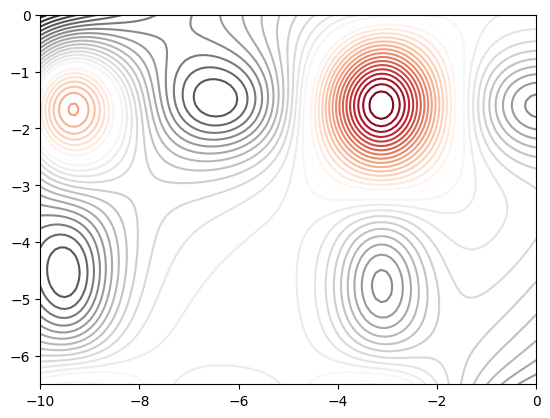

In [ ]:
# Ejemplo optimización

def funcion_objetivo(x_0, x_1):
    '''
    Para la región acotada entre −10<=x_0<=0 y −6.5<=x_1<=0 la función tiene
    múltiples mínimos locales y un único minimo global que se encuentra en
    f(−3.1302468,−1.5821422) = −106.7645367
    '''
    f = np.sin(x_1)*np.exp(1-np.cos(x_0))**2 \
        + np.cos(x_0)*np.exp(1-np.sin(x_1))**2 \
        + (x_0-x_1)**2
    return(f)

# Contour plot función objetivo
x_0 = np.linspace(start = -10, stop = 0, num = 100)
x_1 = np.linspace(start = -6.5, stop = 0, num = 100)
x_0, x_1 = np.meshgrid(x_0, x_1)
z = funcion_objetivo(x_0, x_1)
plt.contour(x_0, x_1, z, 35, cmap='RdGy');

In [ ]:
enjambre = Enjambre(
               n_particulas = 50,
               n_variables  = 2,
               limites_inf  = [-10, -6.5],
               limites_sup  = [0, 0],
               verbose      = False
            )

enjambre.optimizar(
    funcion_objetivo = funcion_objetivo,
    optimizacion     = "minimizar",
    n_iteraciones    = 250,
    inercia          = 0.8,
    reduc_inercia    = True,
    inercia_max      = 0.9,
    inercia_min      = 0.4,
    peso_cognitivo   = 1,
    peso_social      = 2,
    parada_temprana  = True,
    rondas_parada    = 5,
    tolerancia_parada = 10**-3,
    verbose          = False
)

Algoritmo detenido en la iteracion 107 por falta cambio absoluto mínimo de 0.001 durante 5 iteraciones consecutivas.
-------------------------------------------
Optimización finalizada 2023-06-20 23:02:48
-------------------------------------------
Duración optimización: 0.467548131942749
Número de iteraciones: 107


In [ ]:
enjambre

         Enjambre
Número de partículas: 50
Límites inferiores de cada variable: [-10.   -6.5]
Límites superiores de cada variable: [0 0]
Optimizado: True
Iteraciones optimización: 107

Información mejor partícula:
----------------------------
Mejor posición actual: [-3.1227959568163834 -1.5894754840147023]
Mejor valor actual: -106.78773311571896

Resultados tras optimizar:
----------------------------
Posición óptima: [-3.1227959568163834 -1.5894754840147023]
Valor óptimo: -106.78773311571896

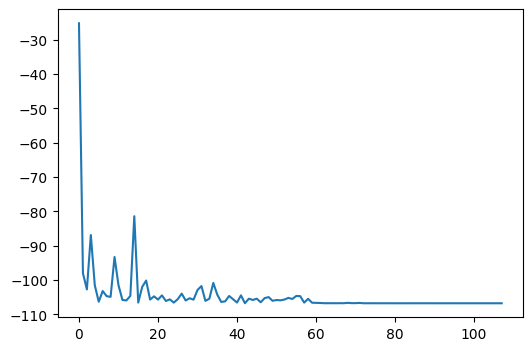

In [ ]:
# Evolución de la optimización
fig = plt.figure(figsize=(6,4))
enjambre.resultados_df['mejor_valor_enjambre'].plot();

In [ ]:
pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Representación evolución partículas gráfico animado.

# Se extrae la posición de las partículas en cada iteración del enjambre
import plotly_express as px

def extraer_posicion(particula):
    posicion = particula.posicion
    return(posicion)

lista_df_temp = []

for i in np.arange(len(enjambre.historico_particulas)):
    posiciones = list(map(extraer_posicion, enjambre.historico_particulas[i]))
    df_temp = pd.DataFrame({"iteracion": i, "posicion": posiciones})
    lista_df_temp.append(df_temp)

df_posiciones = pd.concat(lista_df_temp)

df_posiciones[['x_0','x_1']] = pd.DataFrame(df_posiciones["posicion"].values.tolist(),
                                            index= df_posiciones.index)

df_posiciones.head()

,iteracion,posicion,x_0,x_1
0,0,"[-4.6436234206288995, -4.131924770399971]",-4.643623,-4.131925
1,0,"[-4.674611739938515, -4.7569055230752495]",-4.674612,-4.756906
2,0,"[-4.098880816300059, -4.606924491616741]",-4.098881,-4.606924
3,0,"[-6.13179756224674, -3.033977705422298]",-6.131798,-3.033978
4,0,"[-7.051375955087807, -5.910055122814381]",-7.051376,-5.910055


In [ ]:
px.scatter(
    df_posiciones,
    x       = "x_0",
    y       = "x_1",
    range_x = [-10, 0],
    range_y = [-6.5, 0],
    animation_frame = "iteracion"
)